![alternative text](../../data/svm_chatgpt.png)
![alternative text](../../data/svm1.png)
![alternative text](../../data/svm2.png)
![alternative text](../../data/svm3.png)
![alternative text](../../data/svm4.png)
## That's a lot of scary math. Think of SVM as a neural network tht minimizes the hinge loss.
![alternative text](../../data/hinge.png)

### ChatGPT: 

    The intuition behind the hinge loss is that it encourages the model to correctly classify data points with a margin larger than 1. The larger the margin, the smaller the hinge loss. This aligns with the goal of SVM to maximize the margin between classes while minimizing misclassifications.

    Hinge loss is a convex function, making optimization relatively straightforward.

In [89]:
import torch
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib.pylab import plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



In [97]:
# Let's reuse the functions we created in the linear and non linear regression notebook
class CustomDataset(Dataset):
    def __init__(self,X,Y):
        self.X = X.clone().detach()
        self.Y = Y.clone().detach()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
# let's make this a function 

def dataset(X,Y, batch_size = 32):
    dataset = CustomDataset(X,Y)
    train_size  = int(len(X) * 0.9 )
    valid_test_size  = int(0.1*len(X))

    train_dataset, valid_test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_test_size])
    valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, [valid_test_size//2, valid_test_size//2])


    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    return train_data_loader, valid_data_loader, test_dataset


In [98]:
# Generate synthetic dataset
X, Y = make_classification(n_samples=5000, n_features=2, n_informative=2, n_redundant=0, random_state=1)
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
Y = torch.unsqueeze(Y, 1)


train_data_loader, valid_data_loader, test_dataset = dataset(X,Y)

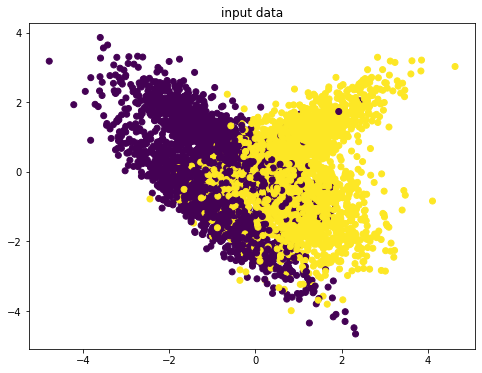

In [99]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0],X[:,1],c=Y)
plt.title('input data')
plt.show()

In [122]:
# Define SVM model class


class KernelSVM(torch.nn.Module):
    def __init__(self):
        super(KernelSVM, self).__init__()
        self.linear = torch.nn.Linear(2, 1)  # 2 input features, 1 output (binary classification)
        self.kernel = nn.GELU()
    
    def forward(self, x):
        kernel_values = self.kernel(x)
        return self.linear(kernel_values)



In [123]:
model = KernelSVM()
optimizer = optim.SGD(model.parameters(), lr=0.001)
lambda_l2 = 0.0001
num_epochs = 1000


In [131]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_data_loader:
        optimizer.zero_grad()
        output = model(inputs) # forward prop
        
        l2 = 0
        for p in model.parameters():
            l2 = l2 + ((p**2).sum())
        loss =  torch.mean(torch.clamp(1 - output * labels, min=0)) + lambda_l2 * l2
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss/len(train_data_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_input, val_labels in valid_data_loader:
            output = model(val_input) # forward prop
            val_loss += torch.mean(torch.clamp(1 - output * val_labels, min=0)).item()

        val_losses.append(val_loss/len(valid_data_loader))

    if (epoch + 1)%10==0:
        print(f'epoch {epoch+1}, train loss:{train_losses[-1]:.4f} , valid loss:{val_losses[-1]:.4f}')
        
        
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("training and validation loss")
plt.legend(["Training loss","validation loss"])
plt.show()
    
    

epoch 10, train loss:0.5407 , valid loss:0.5694
epoch 20, train loss:0.5152 , valid loss:0.5445
epoch 30, train loss:0.5037 , valid loss:0.5371
epoch 40, train loss:0.4992 , valid loss:0.5337
epoch 50, train loss:0.4993 , valid loss:0.5367
epoch 60, train loss:0.4986 , valid loss:0.5322


KeyboardInterrupt: 